# Section 2 (Shuffled controls)

This notebook presents the analysis relevant for the Section 2 of the manuscript.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json

from scipy.stats import pearsonr, spearmanr

import torch
import torch.nn as nn
import torch.nn.functional as F

import logomaker

from NegativeClassOptimization import ml, visualisations
from NegativeClassOptimization import config, utils
from NegativeClassOptimization import preprocessing, datasets

/home/eugen/miniconda3/nco/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Logits ~ Energy

In [3]:
## Functions moved to utils_07. Can be refactored.

from itertools import permutations


task_types = (
    datasets.ClassificationTaskType.ONE_VS_ONE,
    datasets.ClassificationTaskType.ONE_VS_NINE,
    datasets.ClassificationTaskType.HIGH_VS_95LOW,
    datasets.ClassificationTaskType.HIGH_VS_LOOSER,
)

loader = datasets.FrozenMiniAbsolutMLLoader(
    data_dir=Path("../data/Frozen_MiniAbsolut_ML_shuffled/")
)

def task_generator(task_types=task_types):
    """
    Generate tasks for which to compute attributions.
    """
    # Generate 1v1
    seed_split_ids = datasets.FrozenMiniAbsolutMLLoader.generate_seed_split_ids()
    for ag_1, ag_2 in permutations(config.ANTIGENS, r=2):
        for seed_id, split_id in seed_split_ids:            
            task = datasets.ClassificationTask(
                task_type=datasets.ClassificationTaskType.ONE_VS_ONE,
                ag_pos=ag_1,
                ag_neg=ag_2,
                seed_id=seed_id,
                split_id=split_id,
            )
            yield task
    
    # Generate the rest: 1v9, high vs 95low, high vs looser
    seed_split_ids = datasets.FrozenMiniAbsolutMLLoader.generate_seed_split_ids()
    for ag_1 in config.ANTIGENS:
        for seed_id, split_id in seed_split_ids:
            for task_type in task_types:
                
                if task_type == datasets.ClassificationTaskType.ONE_VS_ONE:
                    continue
                
                task = datasets.ClassificationTask(
                    task_type=task_type,
                    ag_pos=ag_1,
                    ag_neg="auto",
                    seed_id=seed_id,
                    split_id=split_id,
                )
                yield task


from utils_07 import get_miniabsolut_dataframes_for_shuffled

In [7]:
logit_energy_corr_path = "../data/Frozen_MiniAbsolut_ML_shuffled/LogitEnergyCorrelations.tsv"
force_run = True
skip_errors_logits = True

if Path(logit_energy_corr_path).exists() and not force_run:
    df_logits = pd.read_csv(logit_energy_corr_path, sep="\t")
else:

    records = []
    for task in task_generator():
        
        if skip_errors_logits:
            try:
                task = loader.load(task, attributions_toload="Test")
            except:
                continue
        else:
            task = loader.load(task, attributions_toload="Test")

        # Get energies
        df = get_miniabsolut_dataframes_for_shuffled(task)

        # Add logits to df
        df_attr = pd.DataFrame.from_records(task.attributions)
        df = pd.merge(df, df_attr[["slide", "logits"]], left_on="Slide", right_on="slide", how='left')

        # Compute correlation and p-val with scipy for all and positive class
        r, p = pearsonr(df["logits"], df["Energy"])
        r_pos, p_pos = pearsonr(df[df["class"] == "positive"]["logits"], df[df["class"] == "positive"]["Energy"])

        # Compute slope for all and positive class
        slope, intercept = np.polyfit(df["logits"], df["Energy"], 1)
        slope_pos, intercept_pos = np.polyfit(df[df["class"] == "positive"]["logits"], df[df["class"] == "positive"]["Energy"], 1)
        
        records.append({
            "task_type": task.task_type.to_str(),
            "ag_pos": task.ag_pos,
            "ag_neg": task.ag_neg,
            "seed_id": task.seed_id,
            "split_id": task.split_id,
            "r": r,
            "p": p,
            "r2": r**2,
            "r_pos": r_pos,
            "r_pos2": r_pos**2,
            "p_pos": p_pos,
            "slope": slope,
            "intercept": intercept,
            "slope_pos": slope_pos,
            "intercept_pos": intercept_pos,
            "logits_mean": df["logits"].mean(),
            "logits_std": df["logits"].std(),
            "Energy_mean": df["Energy"].mean(),
            "Energy_std": df["Energy"].std(),
            "logits_pos_mean": df[df["class"] == "positive"]["logits"].mean(),
            "logits_pos_std": df[df["class"] == "positive"]["logits"].std(),
            "Energy_pos_mean": df[df["class"] == "positive"]["Energy"].mean(),
            "Energy_pos_std": df[df["class"] == "positive"]["Energy"].std(),
            "logits_neg_mean": df[df["class"] == "negative"]["logits"].mean(),
            "logits_neg_std": df[df["class"] == "negative"]["logits"].std(),
            "Energy_neg_mean": df[df["class"] == "negative"]["Energy"].mean(),
            "Energy_neg_std": df[df["class"] == "negative"]["Energy"].std(),
        })

    df_logits = pd.DataFrame.from_records(records)
    df_logits.to_csv(logit_energy_corr_path, index=False, sep='\t')

In [9]:
df_logits.groupby(["task_type"]).agg({"r_pos": ["min", "median", "max"]})

r_pos                    
                     min    median       max
task_type                                   
1v1            -0.966354 -0.042533  0.991047
1v9            -0.960617 -0.529025  0.516523
high_vs_95low  -0.806269  0.098911  0.396236
high_vs_looser -0.311086 -0.098193  0.521871

/tmp/ipykernel_669745/264817336.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))


Text(0.5, 0, 'Task')

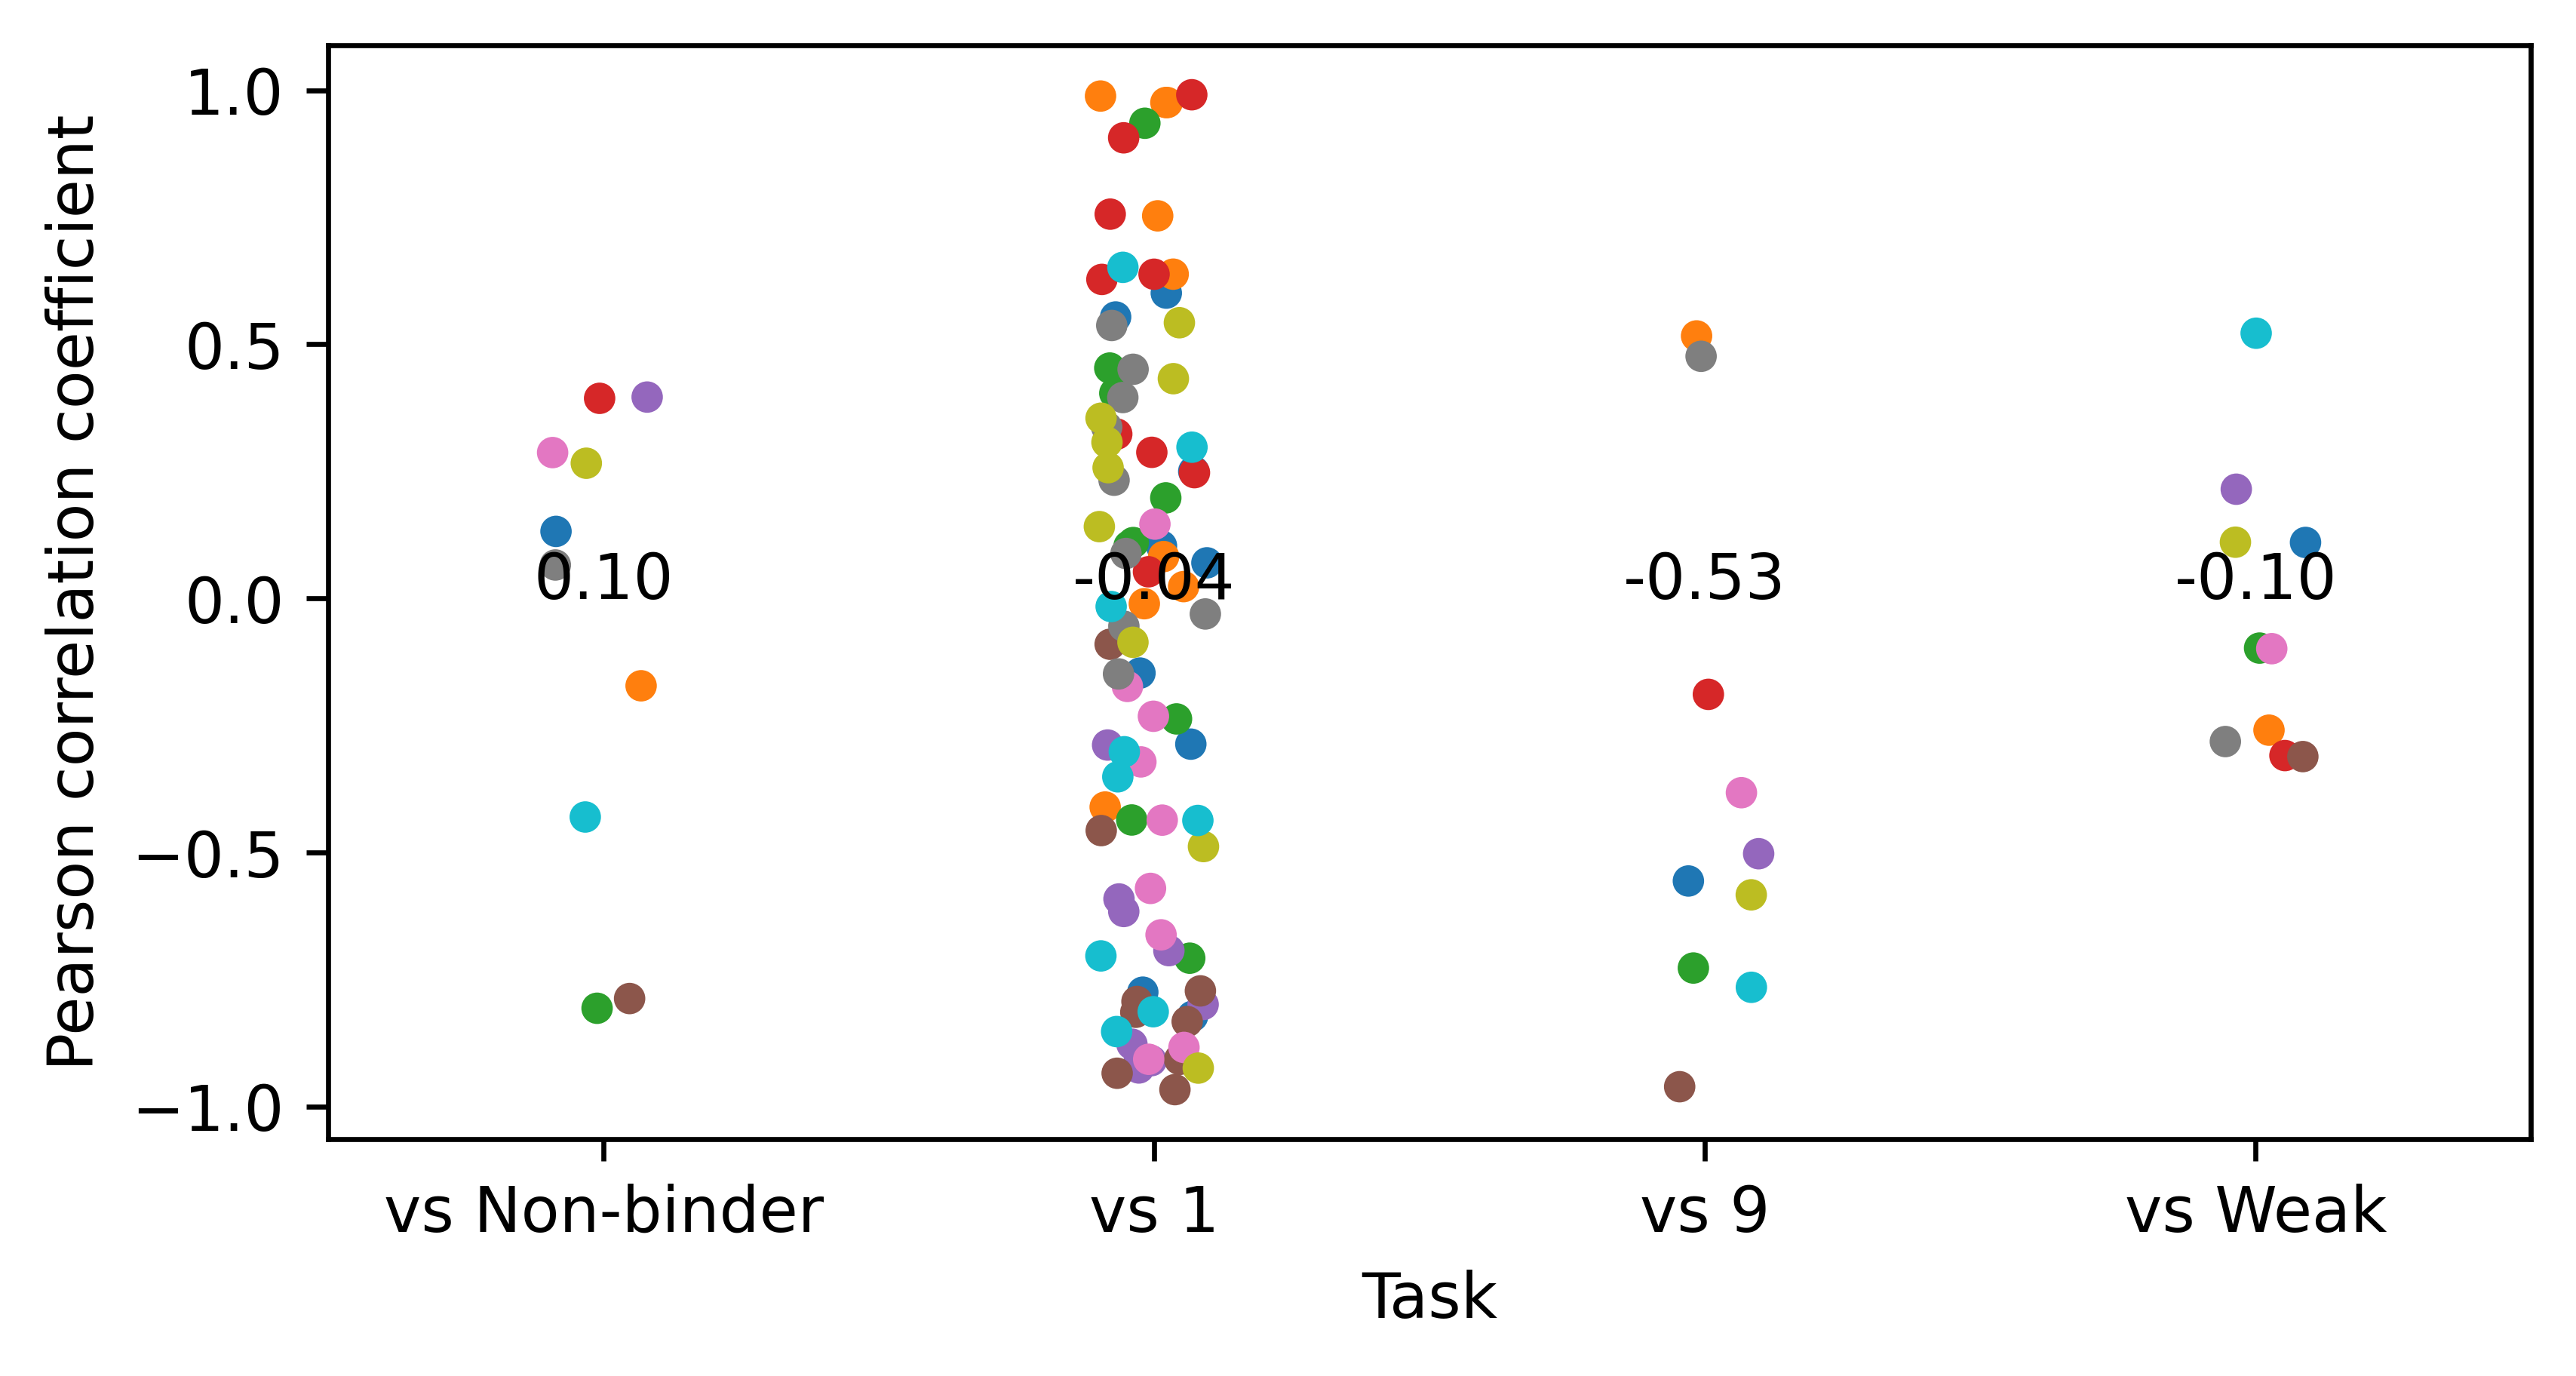

In [11]:
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)
# sns.set_theme(context="paper")
# sns.set_style("white")

task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]
sns.stripplot(
    data=df_logits, 
    x="task_type", 
    y="r_pos", 
    hue="ag_pos", 
    ax=ax, 
    # cmap=visualisations.PlotParams.cmap_antigens,
    order=task_order,
)

# Display no legend
ax.legend_.remove()

# Relabel xticks
ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))

# Add median r_pos per task
r_median_df = df_logits.groupby(["task_type"]).agg({"r_pos": "median"})
for i, row in r_median_df.iterrows():
    ax.text(
        i,
        -0.,
        f"{row['r_pos']:.2f}",
        # Center center
        horizontalalignment='center',
    )

ax.set_ylabel("Pearson correlation coefficient")
ax.set_xlabel("Task")

In [12]:
# Anova test that all are different
from scipy.stats import f_oneway
f_oneway(
    df_logits.query("task_type == 'high_vs_95low'")["r_pos"],
    df_logits.query("task_type == '1v1'")["r_pos"],
    df_logits.query("task_type == '1v9'")["r_pos"],
    df_logits.query("task_type == 'high_vs_looser'")["r_pos"],
)

F_onewayResult(statistic=0.8502341995494028, pvalue=0.46919927044762966)

In [13]:
df_logits["task_type_clean"] = df_logits["task_type"].map(visualisations.PlotParams.map_task_type_to_clean)
df_logits.groupby(["task_type_clean"]).agg({"r_pos": ["min", "median", "max", "size"]}).round(2)

r_pos                  
                  min median   max size
task_type_clean                        
vs 1            -0.97  -0.04  0.99   90
vs 9            -0.96  -0.53  0.52   10
vs Non-binder   -0.81   0.10  0.40   10
vs Weak         -0.31  -0.10  0.52   10

Energy contributions ~ Attributions correlations

In [16]:
from utils_07 import load_energy_contributions_from_task_nonlinear_version
from utils_07 import get_attr_from_records, get_onehotstack_from_records

In [17]:
energy_contributions_path = "../data/Frozen_MiniAbsolut_ML_shuffled/AttributionEnergyContributions.tsv"

force_run_contrib = True
skip_errors_contrib = True

if Path(energy_contributions_path).exists() and not force_run_contrib:
    df_attrib = pd.read_csv(energy_contributions_path, sep="\t")
else:

    records = []
    # for task in task_generator():
    for task in task_generator():
        
        if skip_errors_contrib:
            try:
                task = loader.load(task, attributions_toload="Test")
                stats = load_energy_contributions_from_task_nonlinear_version(
                    task,
                    attr_analysis_name="Test", 
                    attributor_name="DeepLIFT_LOCAL_Test",
                    load_miniabsolut_for_shuffled=True,
                    task_is_loaded=True,

                )
            except:
                continue
        else:
            task = loader.load(task, attributions_toload="Test")
            stats = load_energy_contributions_from_task_nonlinear_version(
                task,
                attr_analysis_name="Test",
                attributor_name="DeepLIFT_LOCAL_Test",
                load_miniabsolut_for_shuffled=True,
                task_is_loaded=True,
            )
        
        records.append(stats)

    df_attrib = pd.DataFrame.from_records(records)
    df_attrib.to_csv(energy_contributions_path, index=False, sep='\t')

/home/eugen/miniconda3/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eugen/miniconda3/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eugen/miniconda3/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eugen/miniconda3/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eugen/miniconda3/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424

/tmp/ipykernel_669745/2153996698.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))


Text(0.5, 0, 'Task')

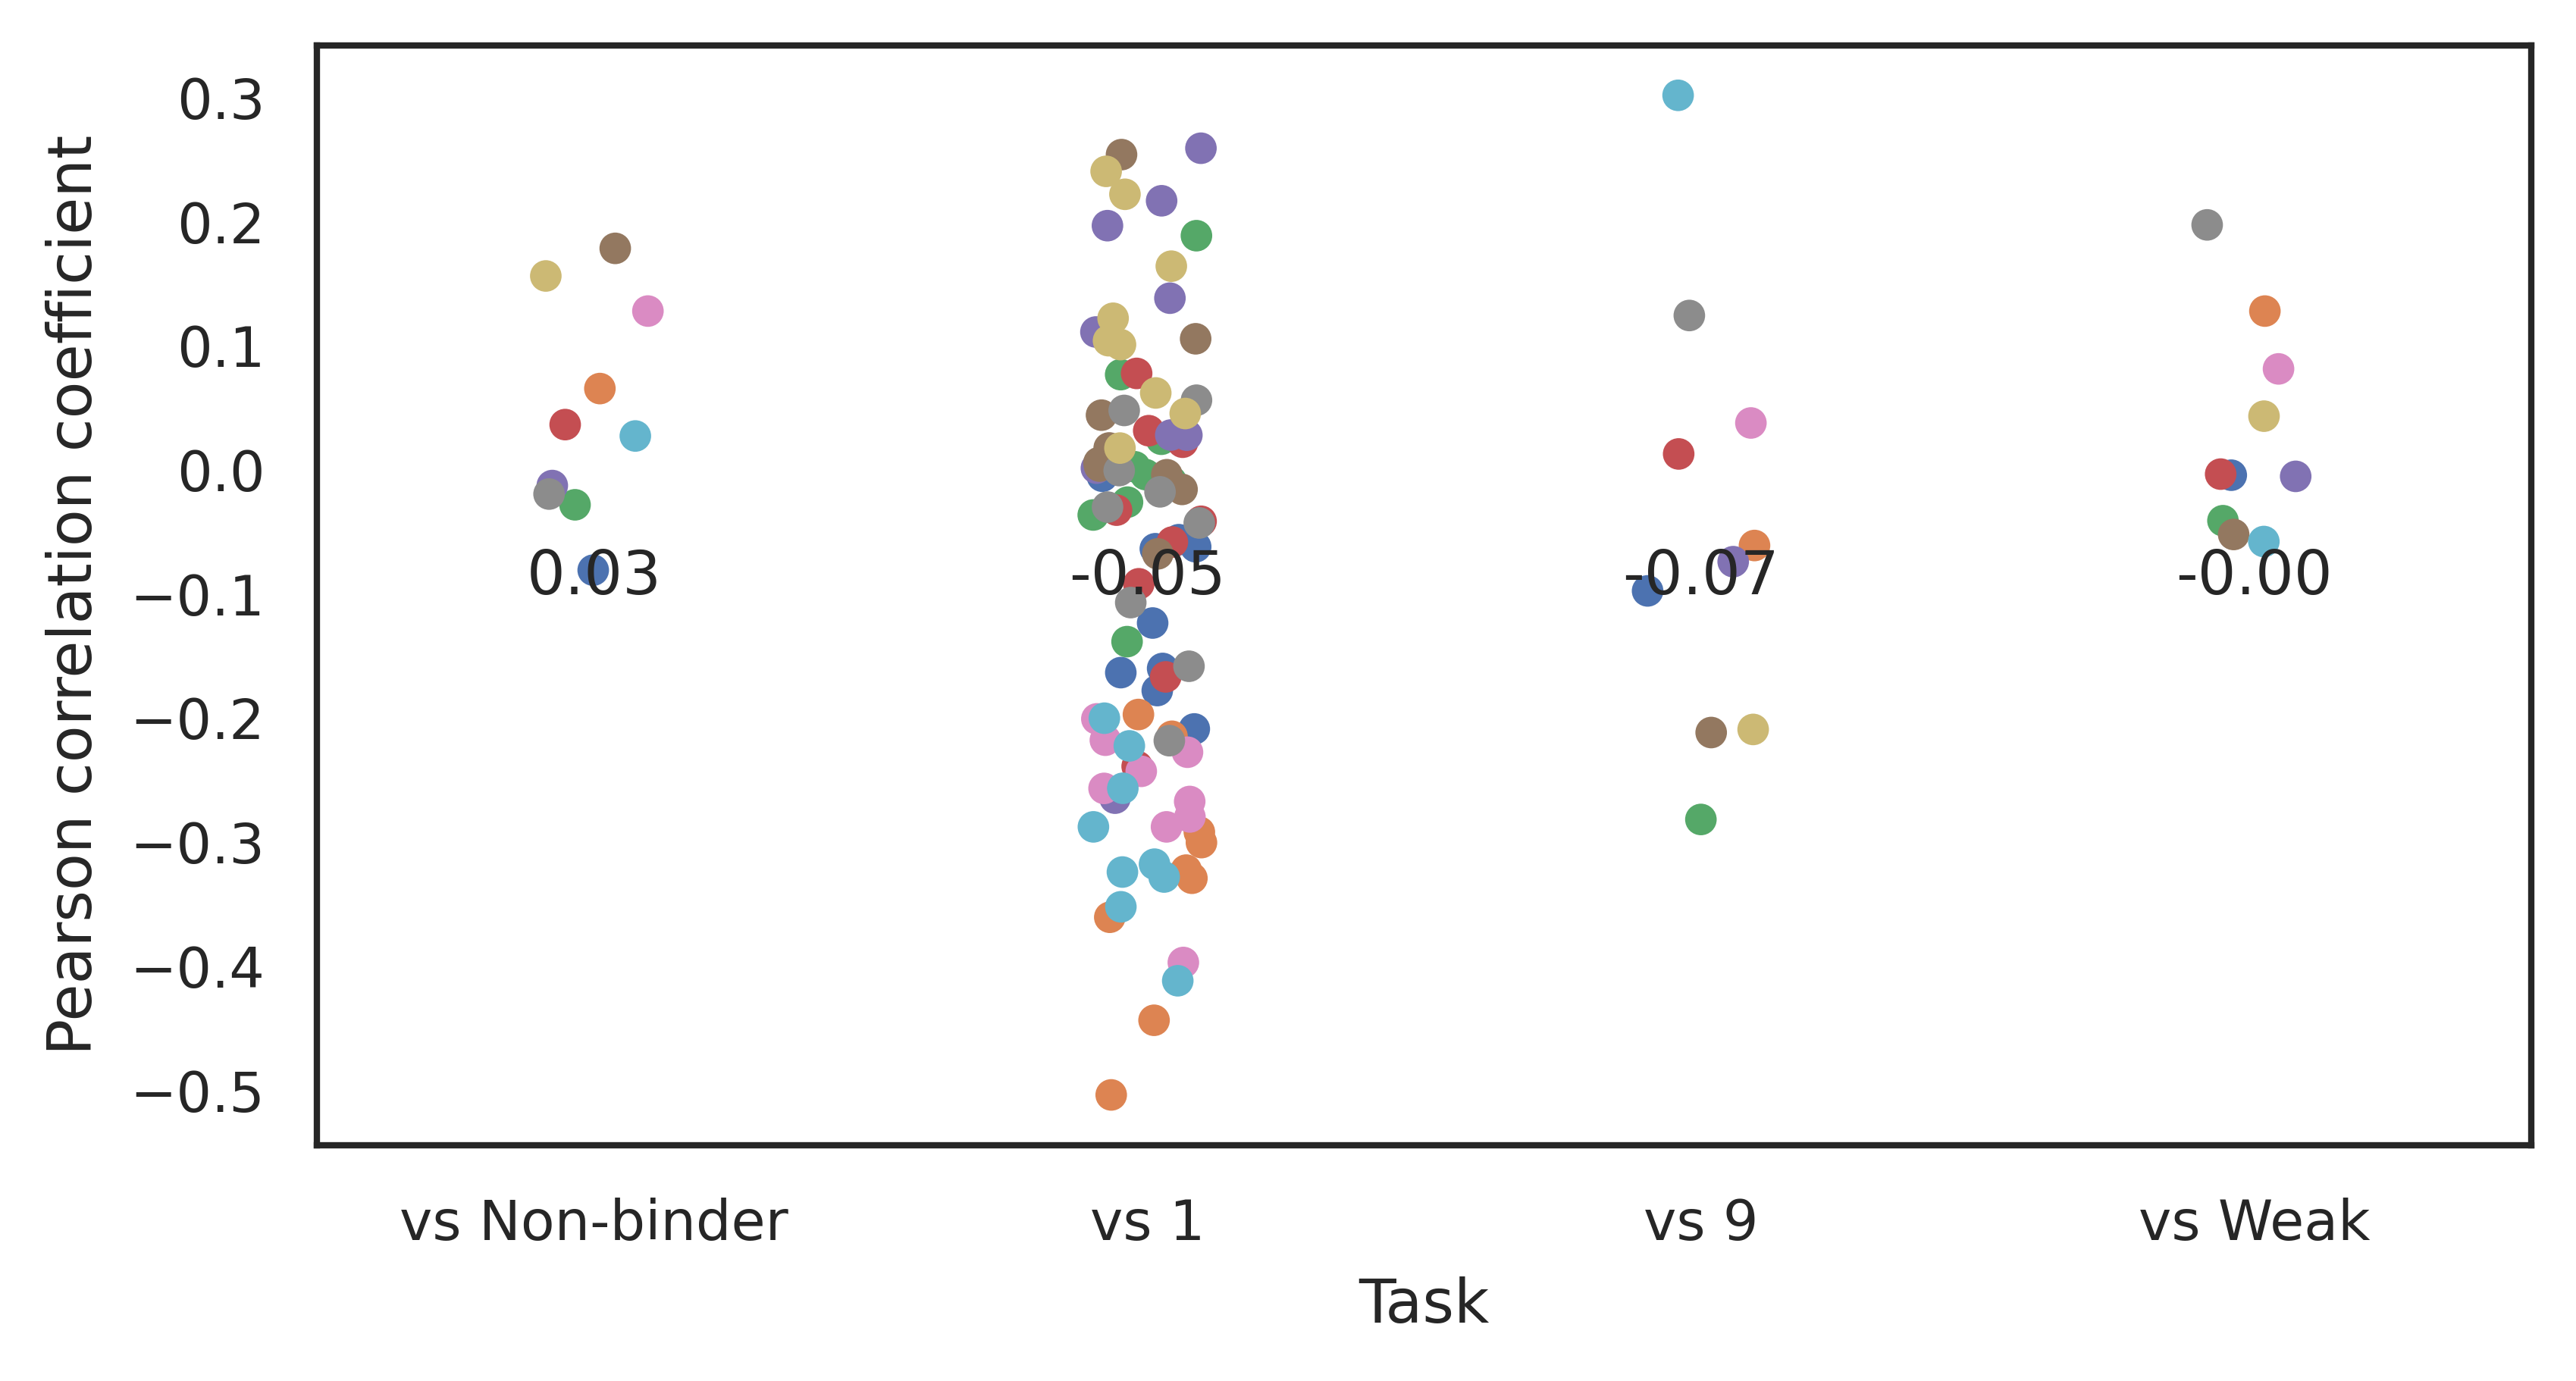

In [19]:
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)
sns.set_theme(context="paper")
sns.set_style("white")

task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]
sns.stripplot(
    data=df_attrib, 
    x="task_type", 
    y="mean_pos_total", 
    order=task_order,
    hue="ag_pos",
    ax=ax,
    # cmap=visualisations.PlotParams.cmap_antigens,
)

ax.legend_.remove()

# Relabel xticks
ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))

# Add median r_pos per task
r_median_df = df_attrib.groupby(["task_type"]).agg({"mean_pos_total": "median"})
for i, row in r_median_df.iterrows():
    ax.text(
        i,
        -0.1,
        f"{row['mean_pos_total']:.2f}",
        # Center center
        horizontalalignment='center',
    )

# ax.set_title("Mean{Correlation(Energycontribution, Attribution)} for positive class")
ax.set_ylabel("Pearson correlation coefficient")
ax.set_xlabel("Task")

In [20]:
# Anova test that all are different
from scipy.stats import f_oneway
f_oneway(
    df_attrib.query("task_type == 'high_vs_95low'")["mean_pos_total"],
    df_attrib.query("task_type == '1v1'")["mean_pos_total"],
    df_attrib.query("task_type == '1v9'")["mean_pos_total"],
    df_attrib.query("task_type == 'high_vs_looser'")["mean_pos_total"],
)

F_onewayResult(statistic=3.069821503294779, pvalue=0.030650819749785188)

In [21]:
df_attrib["task_type_clean"] = df_attrib["task_type"].map(visualisations.PlotParams.map_task_type_to_clean)
df_attrib.groupby(["task_type_clean"]).agg({"mean_pos_total": ["min", "median", "max", "size"]}).round(2)

mean_pos_total                  
                           min median   max size
task_type_clean                                 
vs 1                     -0.50  -0.05  0.26   90
vs 9                     -0.28  -0.07  0.30   10
vs Non-binder            -0.08   0.03  0.18   10
vs Weak                  -0.06  -0.00  0.20   10